In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Based on the provided description of the BraTS dataset, the labels represent different regions of the tumor as follows:

Label 4: GD-enhancing tumor (ET) — This is the most aggressive and enhancing tumor region.
Label 2: Peritumoral edema (ED) — The edema around the tumor.
Label 1: Necrotic and non-enhancing tumor core (NCR/NET) — The necrotic part of the tumor, which does not enhance with contrast.
Updated Mask Labels:
0: Background (non-tumor region).
1: Necrotic and non-enhancing tumor core (NCR/NET).
2: Peritumoral edema (ED).
3: GD-enhancing tumor (ET).
The key change is that you are replacing Label 4 (ET) with Label 3 for the updated classification system.

Mask Processing Considerations:
You need to ensure that your masks have been properly preprocessed and follow the updated label scheme:

Background: 0
NCR/NET: 1
ED: 2
ET: 3

# 1: Imports and Setup

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import torch
import logging
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# 2: Data Preprocessing

In [3]:
def load_nifti_file(filepath):
    """Load a NIfTI file (.nii.gz) and return the data as a float32 array."""
    try:
        data = nib.load(filepath).get_fdata().astype(np.float32)
        return data
    except FileNotFoundError:
        # print(f"File not found: {filepath}")
        return None
    except Exception as e:
        # print(f"Error loading file {filepath}: {str(e)}")
        return None

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_volume(volume):
    """Normalize a 3D volume to the range [0, 1]."""
    assert isinstance(volume, np.ndarray), "Volume must be a numpy array."
    data_scaler = MinMaxScaler()  # Explicitly use MinMaxScaler for data
    volume_flat = volume.flatten().reshape(-1, 1)
    volume_scaled_flat = data_scaler.fit_transform(volume_flat)
    return volume_scaled_flat.reshape(volume.shape)


In [5]:
def gamma_correction(volume, gamma_values):
    """Apply gamma correction to specific modalities."""
    assert isinstance(volume, np.ndarray), "Volume must be a numpy array."
    corrected_volume = np.empty_like(volume)
    for i, gamma in enumerate(gamma_values):
        corrected_volume[..., i] = np.power(volume[..., i], gamma)
    return corrected_volume

In [6]:
def window_setting_operation(volume, window_width, window_level):
    """Apply Window Setting Operation (WSO) to the volume."""
    assert isinstance(volume, np.ndarray), "Volume must be a numpy array."
    U = np.max(volume)
    W = window_width / U
    b = U * (window_level / window_width - 0.5)

    # Apply WSO
    return np.maximum(W * volume + b, 0)

In [7]:
def crop_volume(volume, crop_size=(128, 128, 155)):
    """Crop the volume to a specific size."""
    assert isinstance(volume, np.ndarray), "Volume must be a numpy array."
    assert len(volume.shape) >= 3, "Volume must have at least 3 dimensions."
    
    # Check original volume shape
    original_shape = volume.shape

    # Calculate cropping indices
    center = np.array(original_shape[:3]) // 2
    start = center - np.array(crop_size) // 2
    end = start + np.array(crop_size)

    # Ensure we don't go out of bounds
    start = np.clip(start, 0, None)
    end = np.clip(end, None, original_shape[:3])

    # Crop and return the volume
    return volume[start[0]:end[0], start[1]:end[1], start[2]:end[2]]

# Define the Custom Dataset Class

In [8]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, crop_size=(128, 128, 128), transform=None, is_training=True):
        self.data_dir = data_dir
        self.crop_size = crop_size  # Updated crop size to reflect new depth
        self.transform = transform
        self.is_training = is_training
        self.cases = os.listdir(data_dir)

    def __len__(self):
        return len(self.cases)

    def preprocess_case(self, case_path):
        case = os.path.basename(case_path)

        # Construct paths for modalities
        t1ce_path = os.path.join(case_path, f'{case}_t1ce.nii')
        t2_path = os.path.join(case_path, f'{case}_t2.nii')
        flair_path = os.path.join(case_path, f'{case}_flair.nii')
        mask_path = os.path.join(case_path, f'{case}_seg.nii') if self.is_training else None

        # Load modalities and check if each file exists
        try:
            t1ce = load_nifti_file(t1ce_path)
            t2 = load_nifti_file(t2_path)
            flair = load_nifti_file(flair_path)
            mask = load_nifti_file(mask_path) if self.is_training else None
        except FileNotFoundError as e:
            return None, None

        # Ensure all required modalities are loaded
        modalities = [t1ce, t2, flair]
        loaded_modalities = [normalize_volume(mod) for mod in modalities if mod is not None]
        if len(loaded_modalities) < 3:
            return None, None

        # Apply gamma correction and window setting operation
        gamma_values = [2.9, 3.2, 1.0]  # T1CE, T2, FLAIR (FLAIR unchanged)
        corrected_volumes = gamma_correction(np.stack(loaded_modalities, axis=-1), gamma_values)
        corrected_volumes = window_setting_operation(corrected_volumes, 255, 128)

        # Crop to the required depth (remove first 15 and last 12 slices)
        corrected_volumes = corrected_volumes[:, :, 15:143]

        # Crop the volume spatially
        cropped_volume = crop_volume(corrected_volumes, self.crop_size)

        if self.is_training:
            if mask is not None:
                mask[mask == 4] = 3   # Reassign label 4 to 3 in the mask.
                mask = mask[:, :, 15:143]  # Crop the mask to match the depth
                cropped_mask = crop_volume(mask, self.crop_size)
                cropped_mask = torch.tensor(cropped_mask, dtype=torch.long).permute(2, 0, 1)
            else:
                return None, None  # Skip this case if mask is missing
        else:
            cropped_mask = None

        return cropped_volume, cropped_mask

    def __getitem__(self, idx):
        case_path = os.path.join(self.data_dir, self.cases[idx])
        image, mask = self.preprocess_case(case_path)

        # If a case is skipped (missing files), try the next item
        if image is None or (self.is_training and mask is None):
            return self.__getitem__((idx + 1) % len(self.cases))

        # Convert to torch tensors and permute to (channels, depth, height, width)
        image = torch.tensor(image, dtype=torch.float32).permute(3, 2, 0, 1)  # Shape (Height, Width, Depth, Channels) -> (Channels, Depth, Height, Width)

        # Apply transformations if provided
        if self.transform:
            image, mask = self.transform(image, mask)

        return (image, mask) if self.is_training else image


# Split the Dataset

In [9]:
# Define paths and dataset
data_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
crop_size = (128, 128, 128)
dataset = BrainTumorDataset(data_dir, crop_size=crop_size)

# Split into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
batch_size = 24  # Adjust based on available memory
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [10]:
# # Check the shape and dtype of one batch from each DataLoader
# def check_batch_shapes_and_dtypes(loader, name):
#     for images, masks in loader:
#         print(f"{name} - Images shape: {images.shape}, Images dtype: {images.dtype}")
#         print(f"{name} - Masks shape: {masks.shape}, Masks dtype: {masks.dtype}\n")
#         break  # Only check the first batch to inspect dimensions and dtype

# # Checking train, validation, and test set shapes and dtypes
# check_batch_shapes_and_dtypes(train_loader, "Train")
# check_batch_shapes_and_dtypes(val_loader, "Validation")
# check_batch_shapes_and_dtypes(test_loader, "Test")


#  Visualize Saved Images

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.colors as mcolors

# Custom colormap for segmentation mask
tumor_colors = {
    0: (0.0, 0.0, 0.0),  # Background (black)
    1: (1.0, 0.0, 0.0),  # Necrotic/non-enhancing tumor core (red)
    2: (0.0, 1.0, 0.0),  # Peritumoral edema (green)
    3: (0.0, 0.0, 1.0),  # GD-enhancing tumor (blue)
}
cmap = mcolors.ListedColormap([tumor_colors[i] for i in tumor_colors.keys()])

def visualize_samples_with_colors(train_loader, val_loader):
    # Visualize 5 training samples
    print("Visualizing 5 Training Samples with Tumor Masks:")
    train_count = 0
    for images, masks in train_loader:
        for i in range(min(5, images.shape[0])):  # Ensure we only take up to 5 samples
            image = images[i].cpu().numpy()
            mask = masks[i].cpu().numpy()

            # Check tensor shape and extract the central slice for each modality
            if len(image.shape) == 4:  # Shape: (C, D, H, W)
                central_slice_idx = image.shape[1] // 2  # Get depth slice index
                t1ce_slice = image[0, central_slice_idx, :, :]  # T1CE modality
                t2_slice = image[1, central_slice_idx, :, :]    # T2 modality
                flair_slice = image[2, central_slice_idx, :, :] # FLAIR modality
            else:
                raise ValueError("Unexpected tensor shape. Expected (C, D, H, W).")

            # Extract the corresponding segmentation mask slice
            central_slice_idx_mask = mask.shape[0] // 2  # For 3D mask (D, H, W)
            mask_slice = mask[central_slice_idx_mask, :, :]

            # Plot the T1CE, T2, FLAIR slices and the corresponding segmentation mask
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            axs[0].imshow(t1ce_slice, cmap='gray')
            axs[0].set_title("T1CE Central Slice (Train)")
            axs[0].axis("off")

            axs[1].imshow(t2_slice, cmap='gray')
            axs[1].set_title("T2 Central Slice (Train)")
            axs[1].axis("off")

            axs[2].imshow(flair_slice, cmap='gray')
            axs[2].set_title("FLAIR Central Slice (Train)")
            axs[2].axis("off")

            axs[3].imshow(mask_slice, cmap=cmap, vmin=0, vmax=len(tumor_colors) - 1)
            axs[3].set_title("Segmentation Mask (Train)")
            axs[3].axis("off")

            plt.show()
            train_count += 1
            if train_count == 5:
                break
        if train_count == 5:
            break

    # Visualize 1 validation sample
    print("Visualizing 1 Validation Sample with Tumor Masks:")
    for images, masks in val_loader:
        image = images[0].cpu().numpy()
        mask = masks[0].cpu().numpy()

        # Check tensor shape and extract the central slice for each modality
        if len(image.shape) == 4:  # Shape: (C, D, H, W)
            central_slice_idx = image.shape[1] // 2  # Get depth slice index
            t1ce_slice = image[0, central_slice_idx, :, :]  # T1CE modality
            t2_slice = image[1, central_slice_idx, :, :]    # T2 modality
            flair_slice = image[2, central_slice_idx, :, :] # FLAIR modality
        else:
            raise ValueError("Unexpected tensor shape. Expected (C, D, H, W).")

        # Extract the corresponding segmentation mask slice
        central_slice_idx_mask = mask.shape[0] // 2  # For 3D mask (D, H, W)
        mask_slice = mask[central_slice_idx_mask, :, :]

        # Plot the T1CE, T2, FLAIR slices and the corresponding segmentation mask
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))
        axs[0].imshow(t1ce_slice, cmap='gray')
        axs[0].set_title("T1CE Central Slice (Validation)")
        axs[0].axis("off")

        axs[1].imshow(t2_slice, cmap='gray')
        axs[1].set_title("T2 Central Slice (Validation)")
        axs[1].axis("off")

        axs[2].imshow(flair_slice, cmap='gray')
        axs[2].set_title("FLAIR Central Slice (Validation)")
        axs[2].axis("off")

        axs[3].imshow(mask_slice, cmap=cmap, vmin=0, vmax=len(tumor_colors) - 1)
        axs[3].set_title("Segmentation Mask (Validation)")
        axs[3].axis("off")

        plt.show()
        break


Visualizing 5 Training Samples with Tumor Masks:


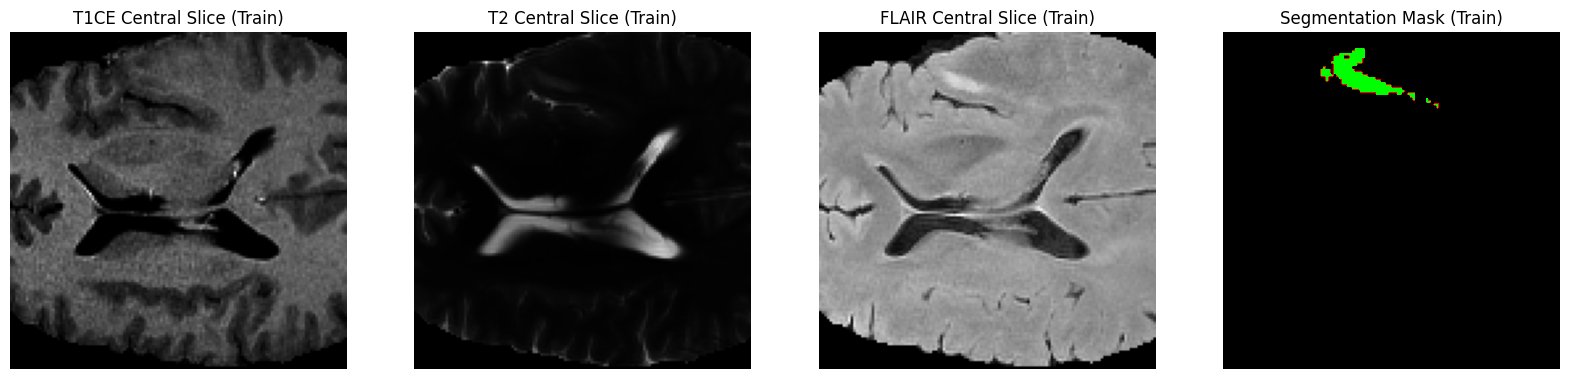

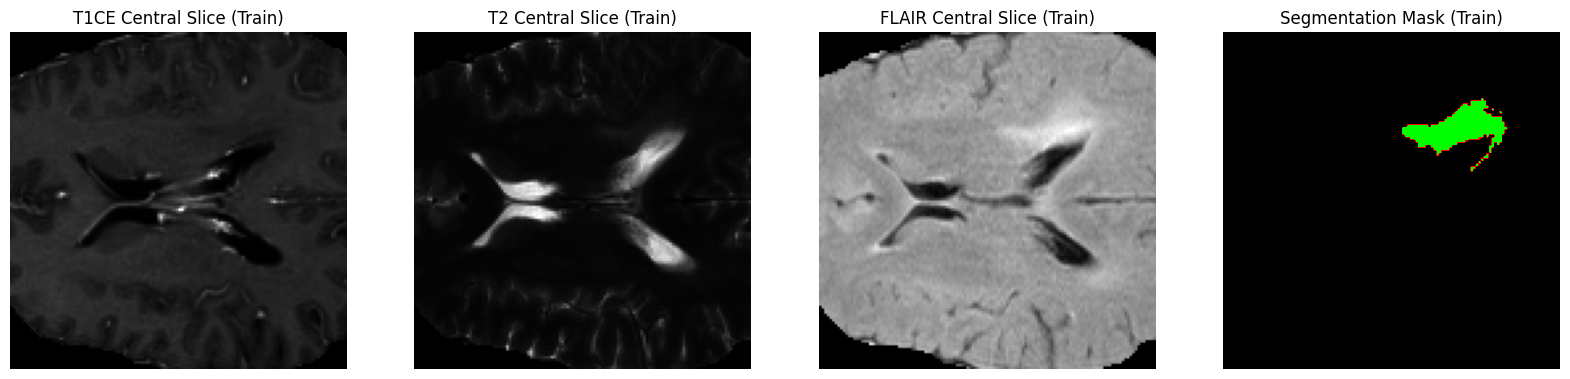

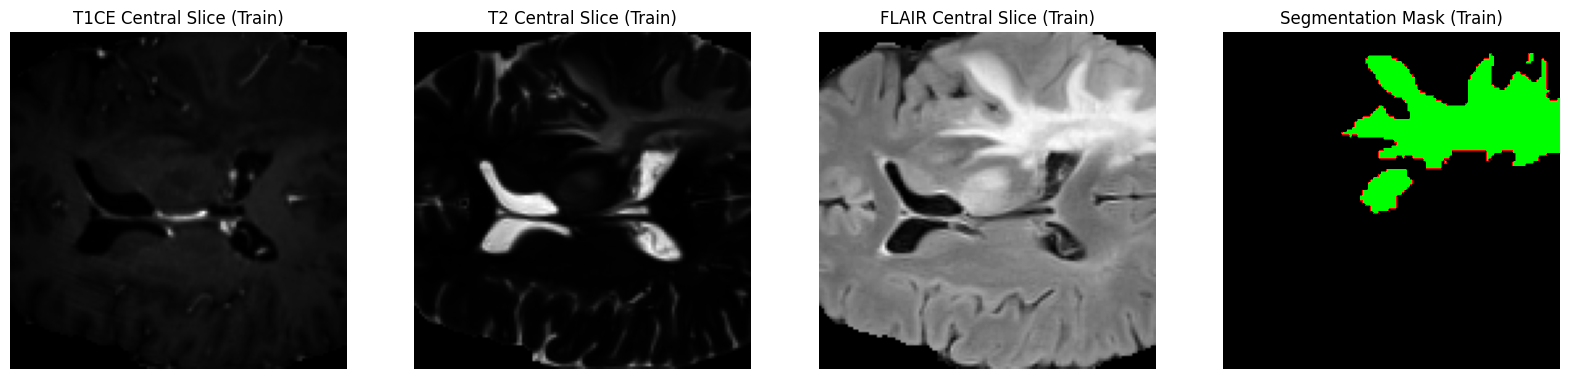

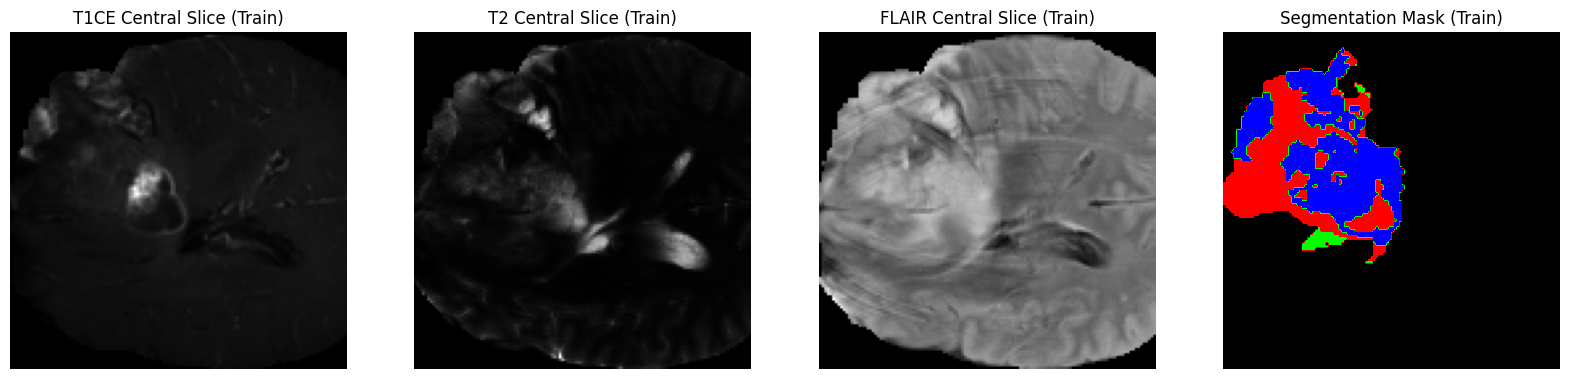

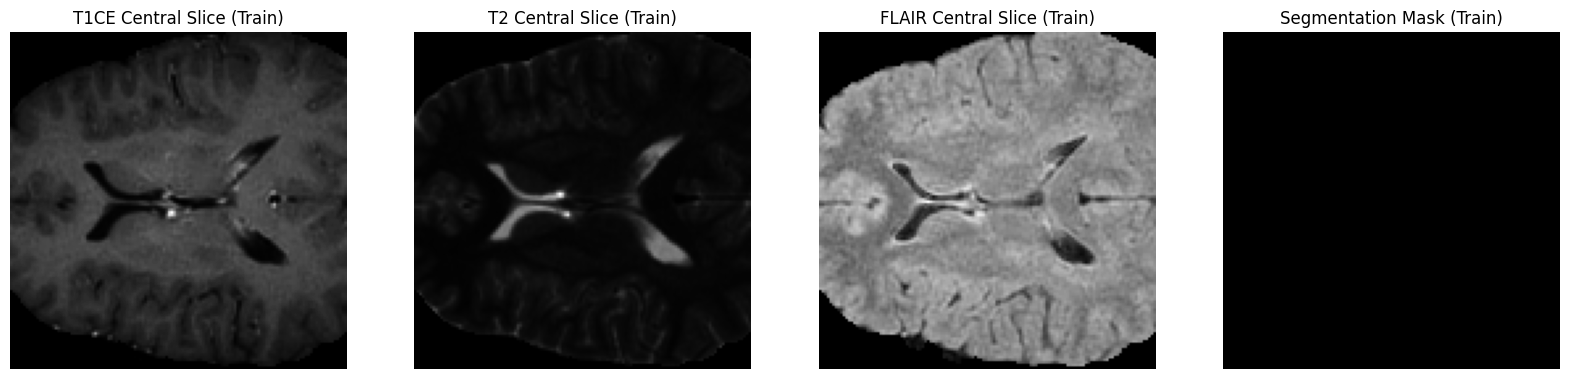

Visualizing 1 Validation Sample with Tumor Masks:


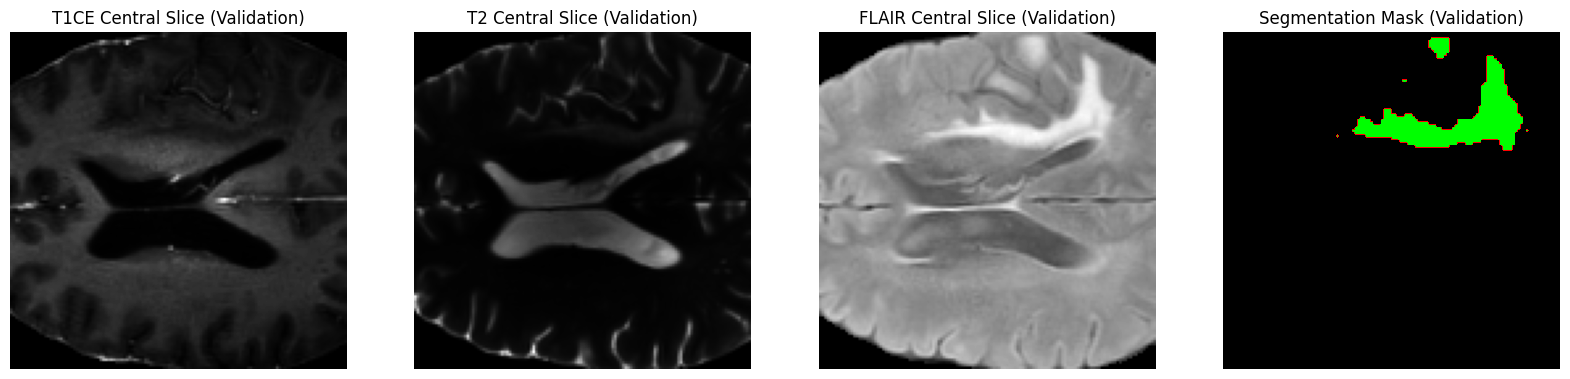

In [12]:
visualize_samples_with_colors(train_loader, val_loader)

# Define the 3D U-Net Model

In [13]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(UNet3D, self).__init__()

        # Encoder path: Feature extraction
        self.encoder1 = self.conv_block(in_channels, 8)
        self.encoder2 = self.conv_block(8, 16)
        self.encoder3 = self.conv_block(16, 32)
        self.encoder4 = self.conv_block(32, 64)

        # Bottleneck layer
        self.bottleneck = self.conv_block(64, 128)

        # Decoder path: Feature reconstruction
        self.upconv4 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(128, 64)

        self.upconv3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(64, 32)

        self.upconv2 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(32, 16)

        self.upconv1 = nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(16, 8)

        # Final layer for output
        self.final_conv = nn.Conv3d(8, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """3D Convolution block with ReLU."""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """Define forward pass with skip connections."""
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool3d(enc1, kernel_size=2))
        enc3 = self.encoder3(F.max_pool3d(enc2, kernel_size=2))
        enc4 = self.encoder4(F.max_pool3d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool3d(enc4, kernel_size=2))

        # Decoder path
        up4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat([up4, enc4], dim=1))

        up3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat([up3, enc3], dim=1))

        up2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat([up2, enc2], dim=1))

        up1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([up1, enc1], dim=1))

        # Final output
        output = self.final_conv(dec1)
        return output

# # Instantiate and test the model
# model = UNet3D(in_channels=3, num_classes=4)
# input_tensor = torch.randn(1, 3, 128, 128, 128)  # Batch size = 1, 3 channels, 128x128x128
# output = model(input_tensor)
# print(output.shape)  # Expected output: [1, 4, 128, 128, 128]


#  Accuracy Function

In [14]:
def compute_metrics(outputs, labels, num_classes):
    # Apply softmax to the model's raw output (logits)
    outputs = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class by taking the argmax over the softmax probabilities
    predictions = torch.argmax(outputs, dim=1)

    # Flatten the predictions and labels to 1D arrays
    true_labels = labels.cpu().numpy().flatten()
    predicted_labels = predictions.cpu().numpy().flatten()

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

    # Initialize metrics dictionaries
    precision = {}
    recall = {}
    specificity = {}
    f1 = {}
    dice = {}
    accuracy = 0.0

    # Calculate per-class confusion matrix and metrics
    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        precision[i] = tp / (tp + fp) if tp + fp > 0 else 0.0
        recall[i] = tp / (tp + fn) if tp + fn > 0 else 0.0
        specificity[i] = tn / (tn + fp) if tn + fp > 0 else 0.0
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if precision[i] + recall[i] > 0 else 0.0
        dice[i] = 2 * tp / (2 * tp + fp + fn) if tp + fp + fn > 0 else 0.0

    # Global accuracy
    accuracy = np.sum(true_labels == predicted_labels) / len(true_labels)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'dice': dice
    }


# Train the Model

In [15]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model setup
model = UNet3D(in_channels=3, num_classes=4)
model = nn.DataParallel(model)  # Multi-GPU training
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss expects integer labels
optimizer = optim.Adam(model.parameters(), lr= 0.001)
scaler = torch.amp.GradScaler(device.type)

num_epochs = 45
grad_accum_steps = 4  # Number of gradient accumulation steps
# early_stop_patience = 5  # Number of epochs to wait before stopping
# best_val_loss = float('inf')
# patience_counter = 0


In [16]:
# Training loop
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, grad_accum_steps):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_specificity = 0.0
    running_dice = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # Use autocast without the device_type argument
        with torch.autocast(device_type="cuda"):
        # with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
            
            outputs = model(images)
            
            if outputs is None:
                continue

            # Calculate the loss and metrics
            loss = criterion(outputs, labels)
            num_classes=4
            # You can include metrics here (accuracy, precision, recall, etc.)
            # Assuming compute_metrics() is defined elsewhere to calculate these metrics
            metrics = compute_metrics(outputs, labels,num_classes)
            
            # Scaler updates
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % grad_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
            
            # # Update running metrics
            running_loss += loss.item()
          
           
            # Average per-class metrics
            running_accuracy += metrics['accuracy']
            running_precision += np.mean(list(metrics['precision'].values()))  # Average precision for all classes
            running_recall += np.mean(list(metrics['recall'].values()))  # Average recall for all classes
            running_f1 += np.mean(list(metrics['f1'].values()))  # Average F1-score for all classes
            running_specificity += np.mean(list(metrics['specificity'].values()))  # Average specificity for all classes
            running_dice += np.mean(list(metrics['dice'].values()))  # Average Dice coefficient for all classes
             # Clear GPU memory periodically to avoid memory fragmentation
            if (batch_idx + 1) % grad_accum_steps == 0:
                torch.cuda.empty_cache()  # Clear cache to avoid fragmentation
        
    # Return average metrics for the epoch
    return (running_loss / len(train_loader),
            running_accuracy / len(train_loader),
            running_precision / len(train_loader),
            running_recall / len(train_loader),
            running_f1 / len(train_loader),
            running_specificity / len(train_loader),
            running_dice / len(train_loader))

# Update validate_one_epoch similarly, ensuring no device_type in autocast()
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_specificity = 0.0
    running_dice = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Use autocast without the device_type argument
            with torch.autocast(device_type="cuda"):
                outputs = model(images)
                
                if outputs is None:
                    continue

                # Calculate the loss and metrics
                loss = criterion(outputs, labels)
                num_classes=4
                metrics = compute_metrics(outputs, labels,num_classes)
            
            # Update running metrics
            running_loss += loss.item()
            running_accuracy += metrics['accuracy']
            running_precision += np.mean(list(metrics['precision'].values()))  # Average precision for all classes
            running_recall += np.mean(list(metrics['recall'].values()))  # Average recall for all classes
            running_f1 += np.mean(list(metrics['f1'].values()))  # Average F1-score for all classes
            running_specificity += np.mean(list(metrics['specificity'].values()))  # Average specificity for all classes
            running_dice += np.mean(list(metrics['dice'].values()))  # Average Dice coefficient for all classes
        
    # Return average metrics for the epoch
    return (running_loss / len(val_loader),
            running_accuracy / len(val_loader),
            running_precision / len(val_loader),
            running_recall / len(val_loader),
            running_f1 / len(val_loader),
            running_specificity / len(val_loader),
            running_dice / len(val_loader))


Tracking epochs with tqdm...


Training Progress:   0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipykernel_23/1219466250.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
Training Progress:   2%|▏         | 1/45 [11:16<8:16:04, 676.46s/it]

Epoch 1/45, Train Loss: 1.0457, Train Accuracy: 0.5047, Train Precision: 0.2673, Train Recall: 0.1726, Train F1: 0.1712, Train Specificity: 0.6791, Train Dice: 0.1712, Val Loss: 0.8242, Val Accuracy: 0.6540, Val Precision: 0.2342, Val Recall: 0.1710, Val F1: 0.1977, Val Specificity: 0.6726, Val Dice: 0.1977


Training Progress:   4%|▍         | 2/45 [19:57<6:59:21, 585.15s/it]

Epoch 2/45, Train Loss: 0.8645, Train Accuracy: 0.7602, Train Precision: 0.2358, Train Recall: 0.1993, Train F1: 0.2152, Train Specificity: 0.7002, Train Dice: 0.2152, Val Loss: 0.7109, Val Accuracy: 0.9284, Val Precision: 0.2387, Val Recall: 0.2428, Val F1: 0.2407, Val Specificity: 0.7430, Val Dice: 0.2407


Training Progress:   7%|▋         | 3/45 [27:55<6:15:23, 536.27s/it]

Epoch 3/45, Train Loss: 0.7064, Train Accuracy: 0.9309, Train Precision: 0.2385, Train Recall: 0.2437, Train F1: 0.2410, Train Specificity: 0.7438, Train Dice: 0.2410, Val Loss: 0.8495, Val Accuracy: 0.8882, Val Precision: 0.2382, Val Recall: 0.2323, Val F1: 0.2352, Val Specificity: 0.7327, Val Dice: 0.2352


Training Progress:   9%|▉         | 4/45 [35:58<5:52:00, 515.14s/it]

Epoch 4/45, Train Loss: 0.7962, Train Accuracy: 0.9122, Train Precision: 0.2378, Train Recall: 0.2393, Train F1: 0.2385, Train Specificity: 0.7395, Train Dice: 0.2385, Val Loss: 0.4822, Val Accuracy: 0.9543, Val Precision: 0.2389, Val Recall: 0.2496, Val F1: 0.2442, Val Specificity: 0.7496, Val Dice: 0.2442


Training Progress:  11%|█         | 5/45 [43:59<5:35:18, 502.97s/it]

Epoch 5/45, Train Loss: 0.5052, Train Accuracy: 0.9528, Train Precision: 0.2385, Train Recall: 0.2497, Train F1: 0.2440, Train Specificity: 0.7497, Train Dice: 0.2440, Val Loss: 0.5295, Val Accuracy: 0.9528, Val Precision: 0.2389, Val Recall: 0.2492, Val F1: 0.2440, Val Specificity: 0.7492, Val Dice: 0.2440


Training Progress:  13%|█▎        | 6/45 [51:59<5:21:45, 495.01s/it]

Epoch 6/45, Train Loss: 0.4823, Train Accuracy: 0.9521, Train Precision: 0.2385, Train Recall: 0.2495, Train F1: 0.2439, Train Specificity: 0.7495, Train Dice: 0.2439, Val Loss: 0.5198, Val Accuracy: 0.9557, Val Precision: 0.2390, Val Recall: 0.2499, Val F1: 0.2443, Val Specificity: 0.7500, Val Dice: 0.2443


Training Progress:  16%|█▌        | 7/45 [59:58<5:10:16, 489.90s/it]

Epoch 7/45, Train Loss: 0.4411, Train Accuracy: 0.9535, Train Precision: 0.2385, Train Recall: 0.2499, Train F1: 0.2440, Train Specificity: 0.7499, Train Dice: 0.2440, Val Loss: 0.4600, Val Accuracy: 0.9550, Val Precision: 0.2390, Val Recall: 0.2498, Val F1: 0.2442, Val Specificity: 0.7498, Val Dice: 0.2442


Training Progress:  18%|█▊        | 8/45 [1:07:57<4:59:55, 486.37s/it]

Epoch 8/45, Train Loss: 0.3934, Train Accuracy: 0.9542, Train Precision: 0.2387, Train Recall: 0.2499, Train F1: 0.2441, Train Specificity: 0.7499, Train Dice: 0.2441, Val Loss: 0.3695, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2443, Val Specificity: 0.7500, Val Dice: 0.2443


Training Progress:  20%|██        | 9/45 [1:15:56<4:50:24, 484.01s/it]

Epoch 9/45, Train Loss: 0.3505, Train Accuracy: 0.9546, Train Precision: 0.2387, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.3642, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2443, Val Specificity: 0.7500, Val Dice: 0.2443


Training Progress:  22%|██▏       | 10/45 [1:24:00<4:42:22, 484.08s/it]

Epoch 10/45, Train Loss: 0.3300, Train Accuracy: 0.9544, Train Precision: 0.2386, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.3294, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  24%|██▍       | 11/45 [1:32:39<4:40:21, 494.74s/it]

Epoch 11/45, Train Loss: 0.3114, Train Accuracy: 0.9544, Train Precision: 0.2386, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.3001, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  27%|██▋       | 12/45 [1:41:25<4:37:21, 504.29s/it]

Epoch 12/45, Train Loss: 0.2884, Train Accuracy: 0.9541, Train Precision: 0.2385, Train Recall: 0.2500, Train F1: 0.2441, Train Specificity: 0.7500, Train Dice: 0.2441, Val Loss: 0.2829, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  29%|██▉       | 13/45 [1:50:04<4:31:16, 508.64s/it]

Epoch 13/45, Train Loss: 0.2847, Train Accuracy: 0.9546, Train Precision: 0.2387, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.2712, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  31%|███       | 14/45 [1:58:06<4:18:37, 500.55s/it]

Epoch 14/45, Train Loss: 0.2588, Train Accuracy: 0.9551, Train Precision: 0.2388, Train Recall: 0.2500, Train F1: 0.2443, Train Specificity: 0.7500, Train Dice: 0.2443, Val Loss: 0.2584, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  33%|███▎      | 15/45 [2:06:04<4:06:55, 493.83s/it]

Epoch 15/45, Train Loss: 0.2587, Train Accuracy: 0.9545, Train Precision: 0.2386, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.2708, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  36%|███▌      | 16/45 [2:14:06<3:57:00, 490.36s/it]

Epoch 16/45, Train Loss: 0.2536, Train Accuracy: 0.9546, Train Precision: 0.2387, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.2381, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  38%|███▊      | 17/45 [2:22:02<3:46:49, 486.07s/it]

Epoch 17/45, Train Loss: 0.2356, Train Accuracy: 0.9551, Train Precision: 0.2388, Train Recall: 0.2500, Train F1: 0.2443, Train Specificity: 0.7500, Train Dice: 0.2443, Val Loss: 0.2297, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  40%|████      | 18/45 [2:30:00<3:37:33, 483.48s/it]

Epoch 18/45, Train Loss: 0.2337, Train Accuracy: 0.9544, Train Precision: 0.2386, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.2248, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  42%|████▏     | 19/45 [2:37:55<3:28:23, 480.91s/it]

Epoch 19/45, Train Loss: 0.2235, Train Accuracy: 0.9539, Train Precision: 0.2385, Train Recall: 0.2500, Train F1: 0.2441, Train Specificity: 0.7500, Train Dice: 0.2441, Val Loss: 0.2089, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  44%|████▍     | 20/45 [2:45:49<3:19:33, 478.93s/it]

Epoch 20/45, Train Loss: 0.2367, Train Accuracy: 0.9543, Train Precision: 0.2386, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.2360, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  47%|████▋     | 21/45 [2:53:41<3:10:46, 476.94s/it]

Epoch 21/45, Train Loss: 0.2264, Train Accuracy: 0.9546, Train Precision: 0.2386, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.1969, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  49%|████▉     | 22/45 [3:01:35<3:02:26, 475.94s/it]

Epoch 22/45, Train Loss: 0.2124, Train Accuracy: 0.9546, Train Precision: 0.2387, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.2309, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  51%|█████     | 23/45 [3:09:35<2:54:56, 477.11s/it]

Epoch 23/45, Train Loss: 0.2272, Train Accuracy: 0.9536, Train Precision: 0.2384, Train Recall: 0.2500, Train F1: 0.2441, Train Specificity: 0.7500, Train Dice: 0.2441, Val Loss: 0.2094, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  53%|█████▎    | 24/45 [3:17:42<2:47:59, 479.99s/it]

Epoch 24/45, Train Loss: 0.2168, Train Accuracy: 0.9537, Train Precision: 0.2384, Train Recall: 0.2500, Train F1: 0.2441, Train Specificity: 0.7500, Train Dice: 0.2441, Val Loss: 0.1843, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  56%|█████▌    | 25/45 [3:25:40<2:39:47, 479.38s/it]

Epoch 25/45, Train Loss: 0.1998, Train Accuracy: 0.9545, Train Precision: 0.2386, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.1947, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  58%|█████▊    | 26/45 [3:33:50<2:32:53, 482.83s/it]

Epoch 26/45, Train Loss: 0.2053, Train Accuracy: 0.9542, Train Precision: 0.2926, Train Recall: 0.2500, Train F1: 0.2441, Train Specificity: 0.7500, Train Dice: 0.2441, Val Loss: 0.1761, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  60%|██████    | 27/45 [3:42:03<2:25:44, 485.83s/it]

Epoch 27/45, Train Loss: 0.1990, Train Accuracy: 0.9546, Train Precision: 0.2558, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.1908, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  62%|██████▏   | 28/45 [3:50:32<2:19:34, 492.64s/it]

Epoch 28/45, Train Loss: 0.1874, Train Accuracy: 0.9547, Train Precision: 0.3045, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.1693, Val Accuracy: 0.9558, Val Precision: 0.2390, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  64%|██████▍   | 29/45 [3:59:13<2:13:39, 501.23s/it]

Epoch 29/45, Train Loss: 0.1835, Train Accuracy: 0.9540, Train Precision: 0.3131, Train Recall: 0.2500, Train F1: 0.2442, Train Specificity: 0.7500, Train Dice: 0.2442, Val Loss: 0.1802, Val Accuracy: 0.9558, Val Precision: 0.2491, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  67%|██████▋   | 30/45 [4:07:47<2:06:15, 505.02s/it]

Epoch 30/45, Train Loss: 0.1907, Train Accuracy: 0.9547, Train Precision: 0.3090, Train Recall: 0.2501, Train F1: 0.2443, Train Specificity: 0.7501, Train Dice: 0.2443, Val Loss: 0.1721, Val Accuracy: 0.9558, Val Precision: 0.2888, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  69%|██████▉   | 31/45 [4:16:28<1:58:59, 509.96s/it]

Epoch 31/45, Train Loss: 0.1709, Train Accuracy: 0.9548, Train Precision: 0.3225, Train Recall: 0.2501, Train F1: 0.2443, Train Specificity: 0.7501, Train Dice: 0.2443, Val Loss: 0.1608, Val Accuracy: 0.9558, Val Precision: 0.2427, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  71%|███████   | 32/45 [4:25:07<1:51:02, 512.50s/it]

Epoch 32/45, Train Loss: 0.1845, Train Accuracy: 0.9539, Train Precision: 0.3272, Train Recall: 0.2502, Train F1: 0.2444, Train Specificity: 0.7502, Train Dice: 0.2444, Val Loss: 0.1883, Val Accuracy: 0.9558, Val Precision: 0.2582, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  73%|███████▎  | 33/45 [4:33:45<1:42:50, 514.23s/it]

Epoch 33/45, Train Loss: 0.1897, Train Accuracy: 0.9540, Train Precision: 0.3215, Train Recall: 0.2502, Train F1: 0.2445, Train Specificity: 0.7502, Train Dice: 0.2445, Val Loss: 0.1909, Val Accuracy: 0.9558, Val Precision: 0.2494, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  76%|███████▌  | 34/45 [4:42:27<1:34:43, 516.68s/it]

Epoch 34/45, Train Loss: 0.1782, Train Accuracy: 0.9538, Train Precision: 0.3394, Train Recall: 0.2502, Train F1: 0.2445, Train Specificity: 0.7502, Train Dice: 0.2445, Val Loss: 0.1768, Val Accuracy: 0.9559, Val Precision: 0.3280, Val Recall: 0.2503, Val F1: 0.2449, Val Specificity: 0.7504, Val Dice: 0.2449


Training Progress:  78%|███████▊  | 35/45 [4:51:08<1:26:19, 517.90s/it]

Epoch 35/45, Train Loss: 0.1919, Train Accuracy: 0.9547, Train Precision: 0.3448, Train Recall: 0.2503, Train F1: 0.2449, Train Specificity: 0.7504, Train Dice: 0.2449, Val Loss: 0.1776, Val Accuracy: 0.9559, Val Precision: 0.3416, Val Recall: 0.2504, Val F1: 0.2451, Val Specificity: 0.7505, Val Dice: 0.2451


Training Progress:  80%|████████  | 36/45 [4:59:49<1:17:47, 518.65s/it]

Epoch 36/45, Train Loss: 0.1760, Train Accuracy: 0.9543, Train Precision: 0.3607, Train Recall: 0.2502, Train F1: 0.2446, Train Specificity: 0.7503, Train Dice: 0.2446, Val Loss: 0.1677, Val Accuracy: 0.9559, Val Precision: 0.3475, Val Recall: 0.2504, Val F1: 0.2451, Val Specificity: 0.7505, Val Dice: 0.2451


Training Progress:  82%|████████▏ | 37/45 [5:08:30<1:09:15, 519.50s/it]

Epoch 37/45, Train Loss: 0.1614, Train Accuracy: 0.9546, Train Precision: 0.3514, Train Recall: 0.2503, Train F1: 0.2449, Train Specificity: 0.7504, Train Dice: 0.2449, Val Loss: 0.1611, Val Accuracy: 0.9558, Val Precision: 0.3219, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7501, Val Dice: 0.2444


Training Progress:  84%|████████▍ | 38/45 [5:17:13<1:00:43, 520.56s/it]

Epoch 38/45, Train Loss: 0.1603, Train Accuracy: 0.9541, Train Precision: 0.3564, Train Recall: 0.2502, Train F1: 0.2446, Train Specificity: 0.7503, Train Dice: 0.2446, Val Loss: 0.1480, Val Accuracy: 0.9559, Val Precision: 0.3246, Val Recall: 0.2502, Val F1: 0.2447, Val Specificity: 0.7503, Val Dice: 0.2447


Training Progress:  87%|████████▋ | 39/45 [5:25:57<52:09, 521.53s/it]  

Epoch 39/45, Train Loss: 0.1647, Train Accuracy: 0.9540, Train Precision: 0.3665, Train Recall: 0.2504, Train F1: 0.2449, Train Specificity: 0.7504, Train Dice: 0.2449, Val Loss: 0.2023, Val Accuracy: 0.9558, Val Precision: 0.2953, Val Recall: 0.2500, Val F1: 0.2444, Val Specificity: 0.7500, Val Dice: 0.2444


Training Progress:  89%|████████▉ | 40/45 [5:34:38<43:27, 521.48s/it]

Epoch 40/45, Train Loss: 0.1821, Train Accuracy: 0.9544, Train Precision: 0.3580, Train Recall: 0.2504, Train F1: 0.2449, Train Specificity: 0.7504, Train Dice: 0.2449, Val Loss: 0.1453, Val Accuracy: 0.9559, Val Precision: 0.3194, Val Recall: 0.2502, Val F1: 0.2447, Val Specificity: 0.7503, Val Dice: 0.2447


Training Progress:  91%|█████████ | 41/45 [5:43:16<34:40, 520.22s/it]

Epoch 41/45, Train Loss: 0.1600, Train Accuracy: 0.9548, Train Precision: 0.3633, Train Recall: 0.2503, Train F1: 0.2449, Train Specificity: 0.7504, Train Dice: 0.2449, Val Loss: 0.1799, Val Accuracy: 0.9559, Val Precision: 0.3679, Val Recall: 0.2508, Val F1: 0.2459, Val Specificity: 0.7508, Val Dice: 0.2459


Training Progress:  93%|█████████▎| 42/45 [5:51:55<26:00, 520.09s/it]

Epoch 42/45, Train Loss: 0.1679, Train Accuracy: 0.9547, Train Precision: 0.3568, Train Recall: 0.2504, Train F1: 0.2451, Train Specificity: 0.7505, Train Dice: 0.2451, Val Loss: 0.1465, Val Accuracy: 0.9559, Val Precision: 0.3183, Val Recall: 0.2502, Val F1: 0.2447, Val Specificity: 0.7503, Val Dice: 0.2447


Training Progress:  96%|█████████▌| 43/45 [6:00:36<17:20, 520.11s/it]

Epoch 43/45, Train Loss: 0.1519, Train Accuracy: 0.9546, Train Precision: 0.3585, Train Recall: 0.2504, Train F1: 0.2449, Train Specificity: 0.7504, Train Dice: 0.2449, Val Loss: 0.1501, Val Accuracy: 0.9559, Val Precision: 0.3130, Val Recall: 0.2501, Val F1: 0.2446, Val Specificity: 0.7503, Val Dice: 0.2446


Training Progress:  98%|█████████▊| 44/45 [6:09:13<08:39, 519.24s/it]

Epoch 44/45, Train Loss: 0.1634, Train Accuracy: 0.9548, Train Precision: 0.3584, Train Recall: 0.2503, Train F1: 0.2449, Train Specificity: 0.7504, Train Dice: 0.2449, Val Loss: 0.1399, Val Accuracy: 0.9559, Val Precision: 0.3355, Val Recall: 0.2503, Val F1: 0.2450, Val Specificity: 0.7504, Val Dice: 0.2450


Training Progress: 100%|██████████| 45/45 [6:17:54<00:00, 503.88s/it]

Epoch 45/45, Train Loss: 0.1566, Train Accuracy: 0.9543, Train Precision: 0.3652, Train Recall: 0.2505, Train F1: 0.2451, Train Specificity: 0.7505, Train Dice: 0.2451, Val Loss: 0.1443, Val Accuracy: 0.9559, Val Precision: 0.3070, Val Recall: 0.2501, Val F1: 0.2446, Val Specificity: 0.7502, Val Dice: 0.2446
Saved best model checkpoint.
Training completed.
Training metrics saved to /kaggle/working/training_metrics_3D_UNET.csv.
Plotting and saving graphs...


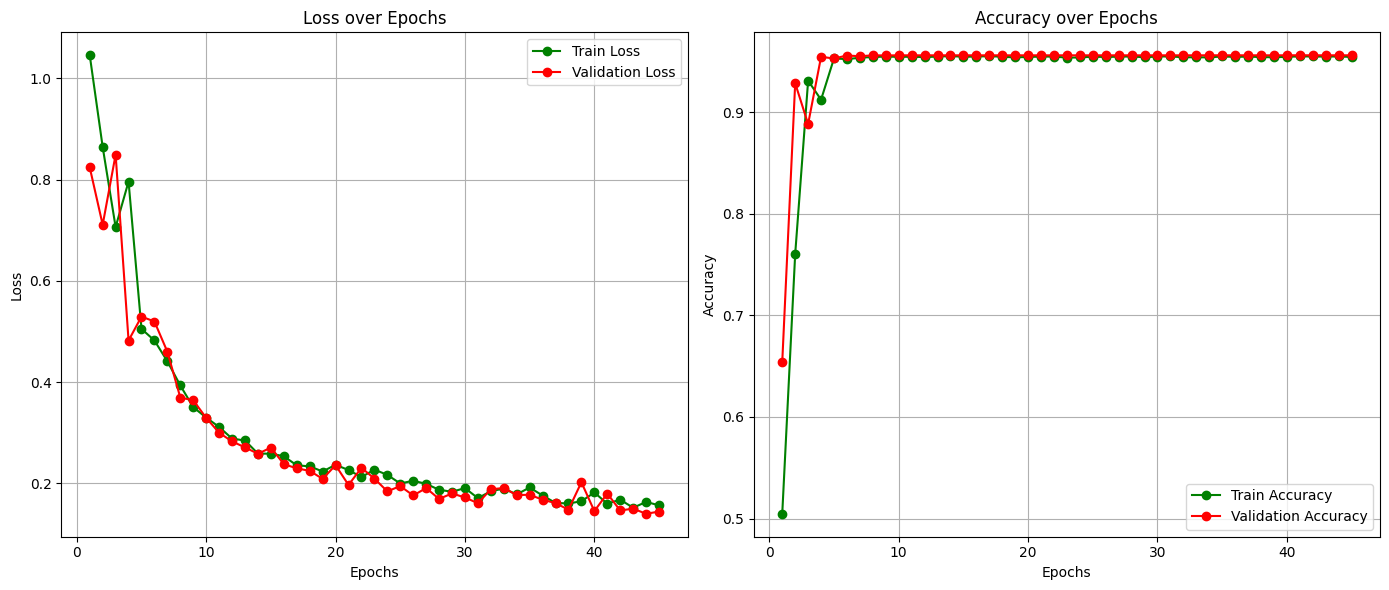

Graph saved at /kaggle/working/training_graph_3D_UNET.png.


In [17]:
# Initialize lists to track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Directory to save outputs in Kaggle
output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=[
    "Epoch", 
    "Train Loss", "Validation Loss", 
    "Train Accuracy", "Validation Accuracy", 
    "Train Precision", "Validation Precision",
    "Train Recall", "Validation Recall",
    "Train F1", "Validation F1",
    "Train Specificity", "Validation Specificity",
    "Train Dice", "Validation Dice"
])

# Training loop with tqdm
print("Tracking epochs with tqdm...")
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    # Training phase
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_specificity, train_dice = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device, grad_accum_steps
    )

    # Validation phase
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_specificity, val_dice = validate_one_epoch(
        model, val_loader, criterion, device
    )

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Add metrics to the DataFrame (using pd.concat instead of append)
    new_row = pd.DataFrame({
        "Epoch": [epoch + 1],
        "Train Loss": [train_loss],
        "Validation Loss": [val_loss],
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [val_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [val_recall],
        "Train F1": [train_f1],
        "Validation F1": [val_f1],
        "Train Specificity": [train_specificity],
        "Validation Specificity": [val_specificity],
        "Train Dice": [train_dice],
        "Validation Dice": [val_dice]
    })
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    # Print metrics for both training and validation
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, "
          f"Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, Train Specificity: {train_specificity:.4f}, "
          f"Train Dice: {train_dice:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, "
          f"Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val Specificity: {val_specificity:.4f}, "
          f"Val Dice: {val_dice:.4f}")

    # Save checkpoint if validation loss improves
    if epoch+1 == num_epochs:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(output_dir, 'best_model_3D_UNET.pth'))
        torch.save(model, os.path.join(output_dir, "entire_model_3D_UNET.pth"))
        print("Saved best model checkpoint.")

print("Training completed.")

# Save metrics DataFrame as a CSV file
csv_path = os.path.join(output_dir, 'training_metrics_3D_UNET.csv')
metrics_df.to_csv(csv_path, index=False)
print(f"Training metrics saved to {csv_path}.")

# Plotting the loss and accuracy
print("Plotting and saving graphs...")

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o', color="green")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o', color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker='o', color="green")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o', color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()

plt.tight_layout()

# Save the plot
graph_path = os.path.join(output_dir, 'training_graph_3D_UNET.png')
plt.savefig(graph_path)
plt.show()

print(f"Graph saved at {graph_path}.")


# Testing

/tmp/ipykernel_23/3038892260.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


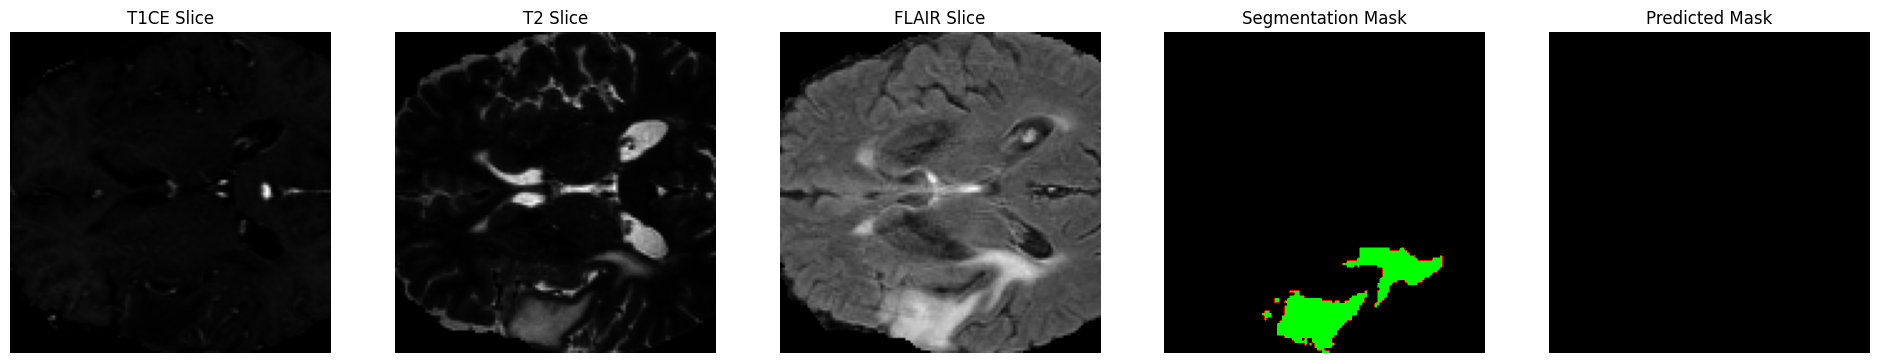

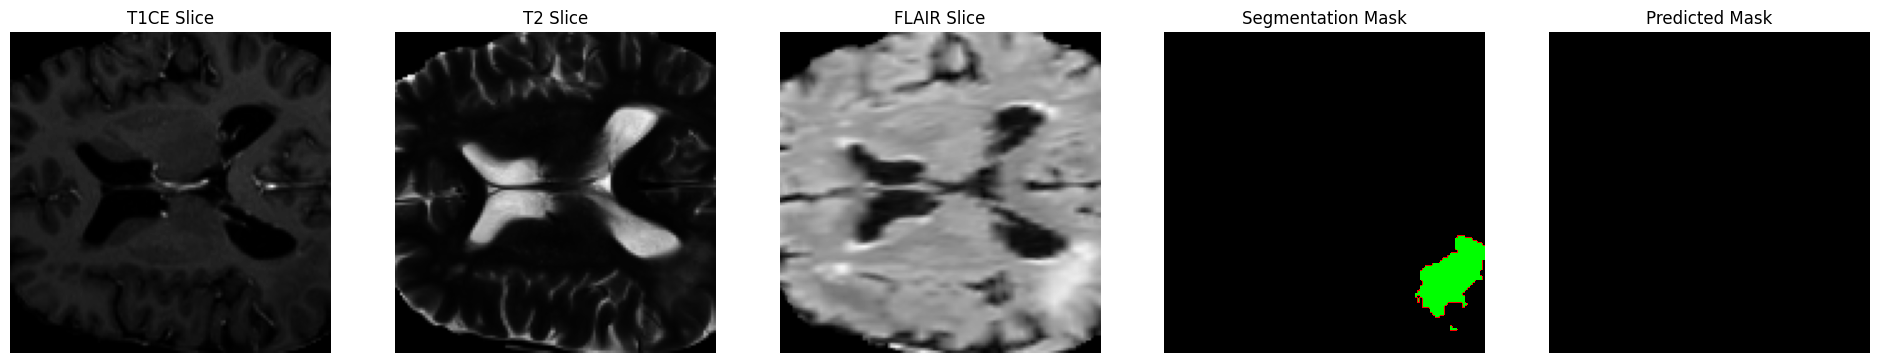

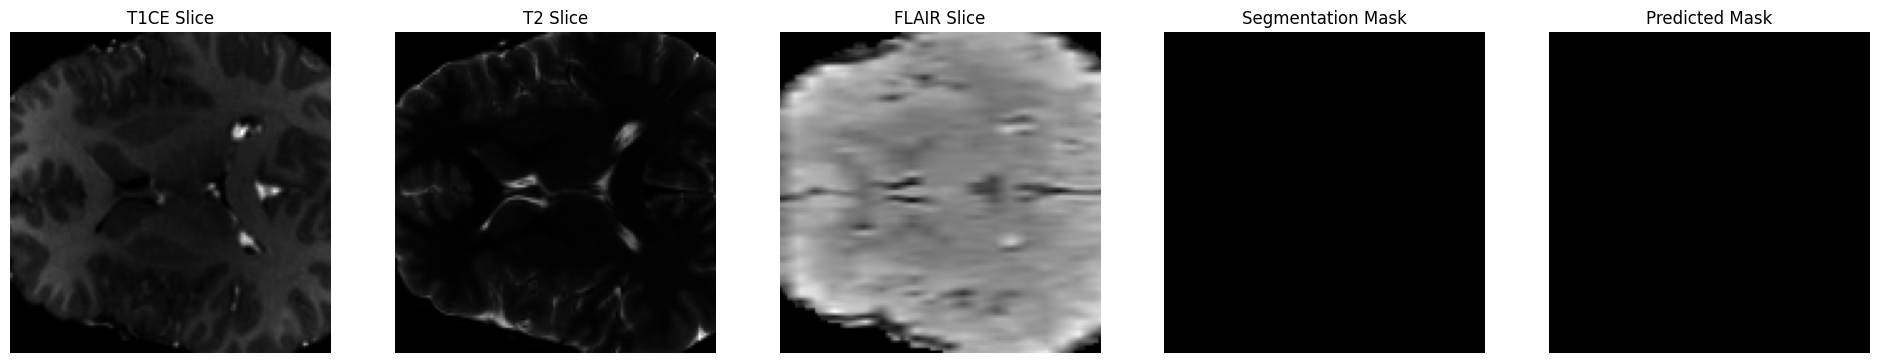

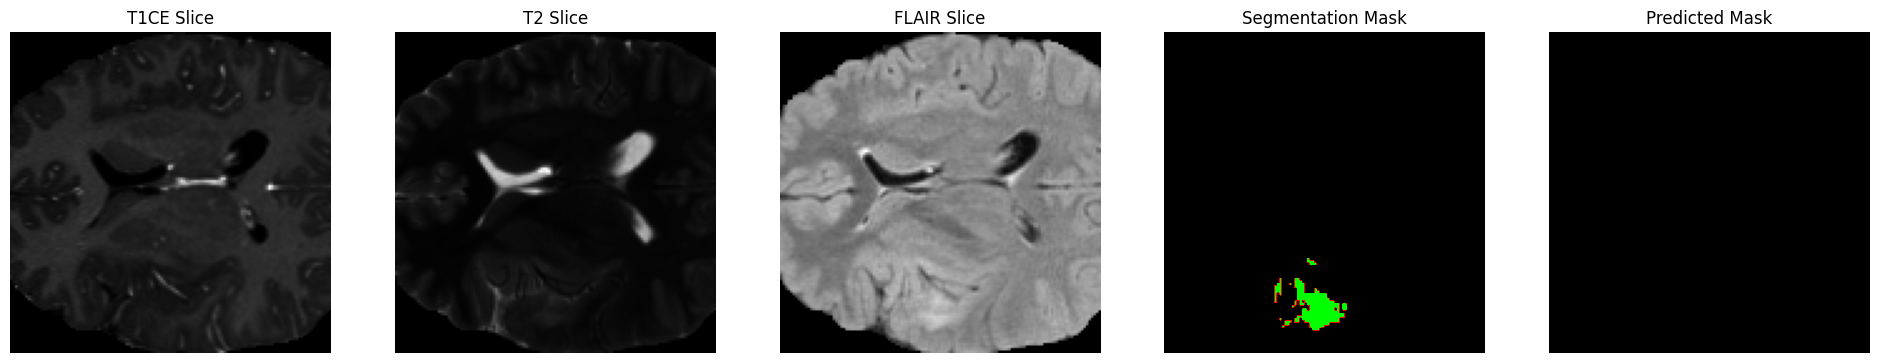

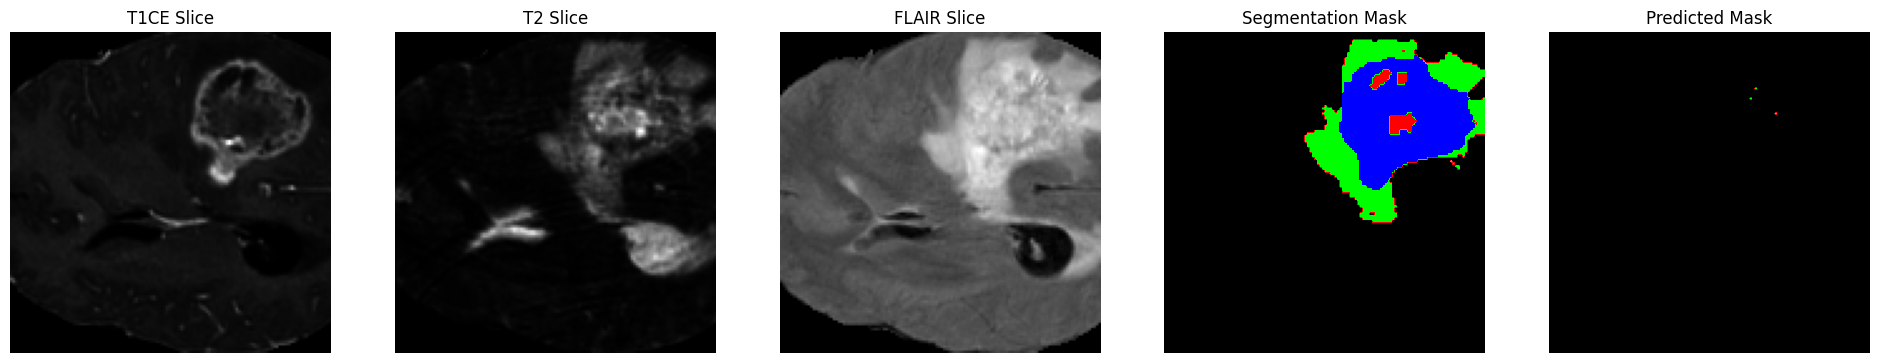

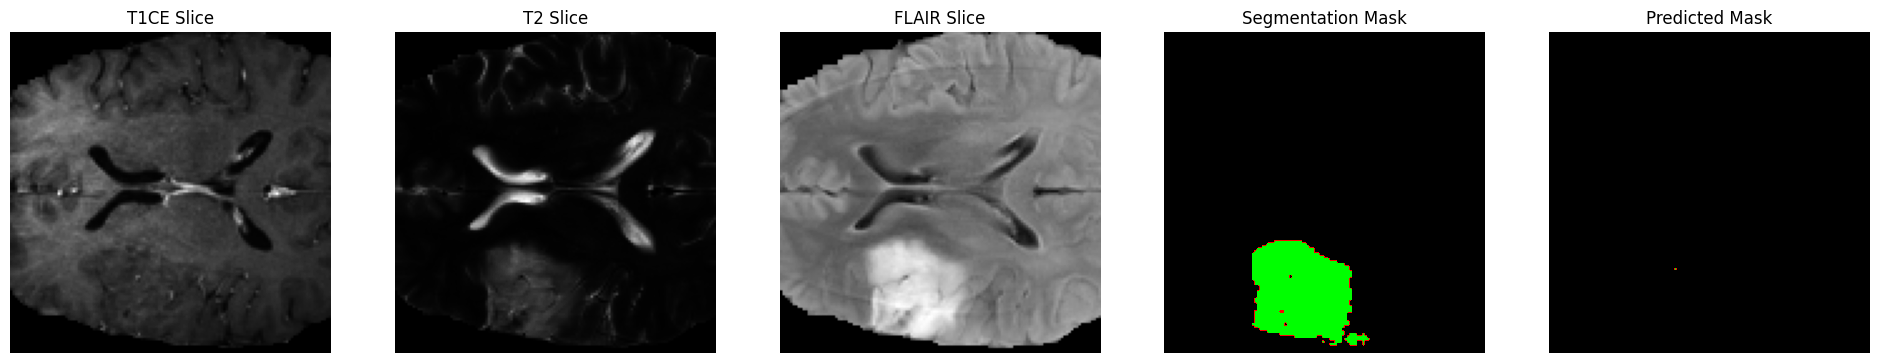

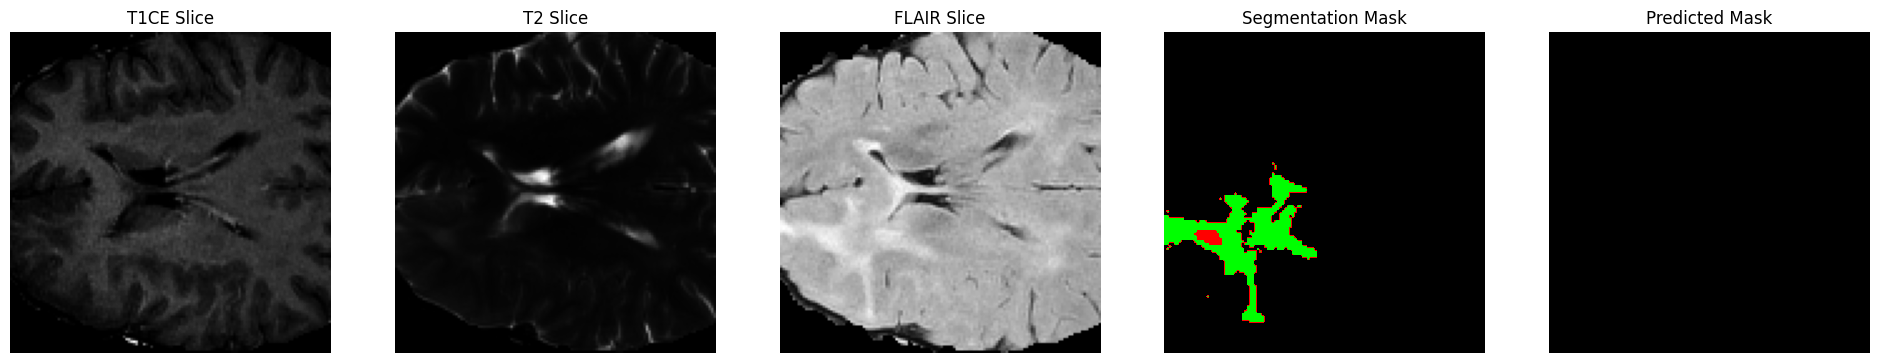

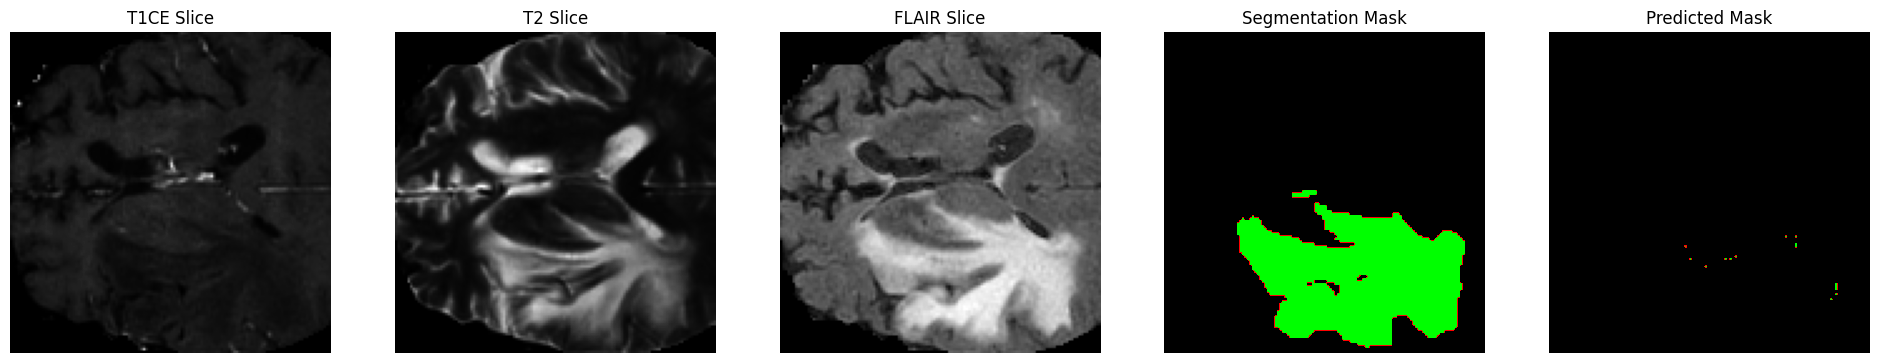

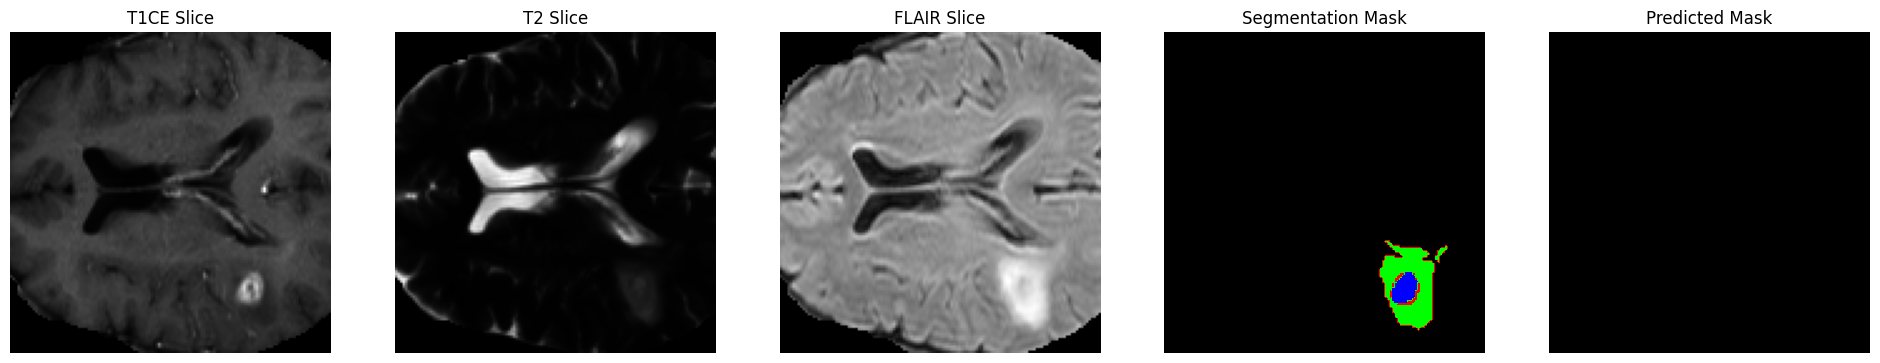

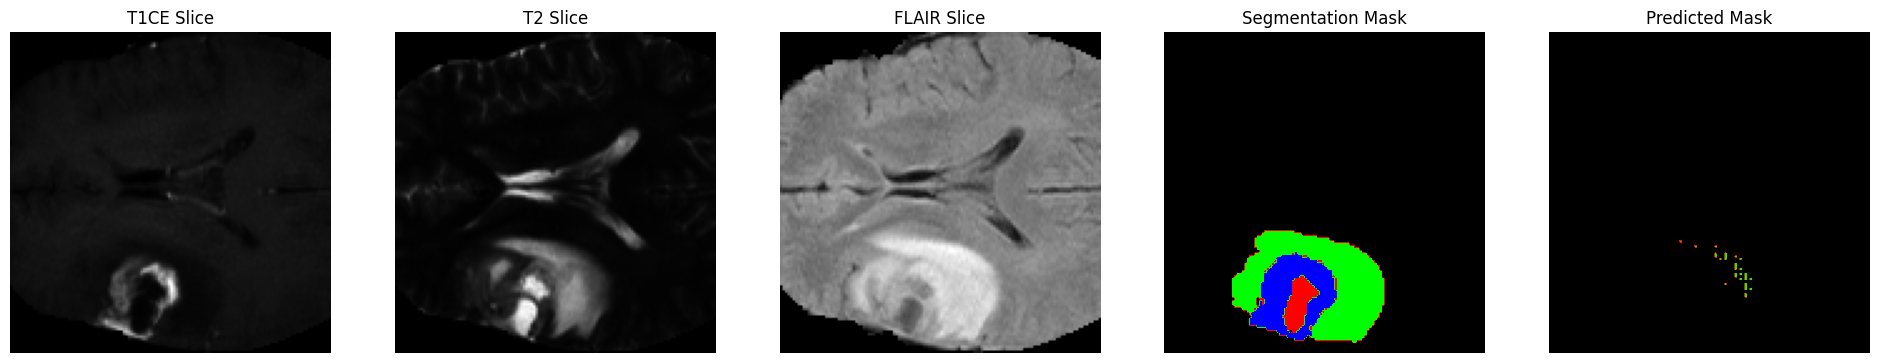

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.colors as mcolors

# Define a custom colormap for the segmentation mask
tumor_colors = {
    0: (0.0, 0.0, 0.0),  # Background (black)
    1: (1.0, 0.0, 0.0),  # Necrotic/non-enhancing tumor core (red)
    2: (0.0, 1.0, 0.0),  # Peritumoral edema (green)
    3: (0.0, 0.0, 1.0),  # GD-enhancing tumor (blue)
}
cmap = mcolors.ListedColormap([tumor_colors[i] for i in tumor_colors.keys()])

def visualize_results(image, mask, prediction, cmap, tumor_colors):
    """
    Visualize T1CE, T2, FLAIR modalities, the segmentation mask, and predicted mask.
    """
    central_slice_idx = image.shape[1] // 2  # Get central slice index for 3D data
    t1ce_slice = image[0, central_slice_idx, :, :]  # T1CE modality
    t2_slice = image[1, central_slice_idx, :, :]    # T2 modality
    flair_slice = image[2, central_slice_idx, :, :] # FLAIR modality
    mask_slice = mask[central_slice_idx, :, :]      # Ground truth mask
    pred_slice = prediction[central_slice_idx, :, :]  # Predicted mask

    # Plot the slices
    fig, axs = plt.subplots(1, 5, figsize=(24, 6))
    axs[0].imshow(t1ce_slice, cmap='gray')
    axs[0].set_title("T1CE Slice")
    axs[0].axis("off")

    axs[1].imshow(t2_slice, cmap='gray')
    axs[1].set_title("T2 Slice")
    axs[1].axis("off")

    axs[2].imshow(flair_slice, cmap='gray')
    axs[2].set_title("FLAIR Slice")
    axs[2].axis("off")

    axs[3].imshow(mask_slice, cmap=cmap, vmin=0, vmax=len(tumor_colors) - 1)
    axs[3].set_title("Segmentation Mask")
    axs[3].axis("off")

    axs[4].imshow(pred_slice, cmap=cmap, vmin=0, vmax=len(tumor_colors) - 1)
    axs[4].set_title("Predicted Mask")
    axs[4].axis("off")

    plt.show()

def test_model(model_path, test_loader, device):
    """
    Test the model and visualize results.
    """
    # Load the saved model
    model = torch.load(model_path, map_location=device)
    model.eval()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.cpu().numpy()
            
            # Predict and visualize for the first batch
            predictions = model(images)
            predictions = torch.argmax(predictions, dim=1).cpu().numpy()  # Convert predictions to class indices
            
            for i in range(min(5, images.shape[0])):  # Visualize up to 5 samples
                image = images[i].cpu().numpy()  # Convert image to numpy
                mask = masks[i]
                prediction = predictions[i]
                visualize_results(image, mask, prediction, cmap, tumor_colors)
            

# Example usage
if __name__ == "__main__":
    # Specify the saved model path
    saved_model_path = "entire_model_3D_UNET.pth"

    # Assume `test_loader` and `device` are already defined
    test_model(saved_model_path, test_loader, device)


In [19]:
import torch

def count_parameters(model):
    """
    Count the total number of parameters in the model.
    
    Args:
        model (torch.nn.Module): The PyTorch model.
        
    Returns:
        int: Total number of parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# Load your model
model = torch.load(saved_model_path)
model = model.to(device)  # Ensure the model is on the correct device

# Print the total number of parameters
total_params = count_parameters(model)
print(f'Total Parameters in the Model: {total_params}')


Total Parameters in the Model: 1412228


/tmp/ipykernel_23/2195096236.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(saved_model_path)
